# Convex Optimisation
## Exam Q6

Answers/code by Raphael Reme

Let's re-use the barrier method implemented for HM3:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def vectorize(vector):
    """Reshape any array to be of size (n, 1). (Vertical point of view)

    Useful to be sure of our matricial dot/element-wise product.
    """
    return vector.reshape((vector.size, 1))

def centeringstep(Q, p, A, b, t, v0, eps):
    """Minimize t(v^T.Q.v + p^T.v) - log(b-A.v)^T.1 with the Newton method.

    Attrs:
        Q (Array nxn)
        p (Array nx1)
        A (Array mxn)
        b (Array mx1)
        t (float): Step in the barrier method.
        v0 (Array nx1): Initial point.
        eps (float): Precision on the solution.

    Returns:
        List[Array nx1]: The list of v values during the minimization. 
    """
    def f(v):
        return t * (v.T @ Q @ v + p.T @ v) - np.log(b - A @ v).sum()

    # backtracking parameters
    alpha = 0.25
    beta = 0.5

    ones = np.ones(b.shape)
    v = [v0]
    while True:
        # Compute Hessian and gradient
        A_bar = A / (b - A @ v[-1])
        grad = t * (2*Q @ v[-1] + p) + A_bar.T @ ones
        hessian = 2*t*Q + A_bar.T @ A_bar

        # Compute Newton step and decrement
        # dx = -Hess^-1.Grad and lambda2 = Grad.Hess^-1.Grad
        # <=> Hess.dx = -Grad and lambda2 = -Grad.dx
        dx = np.linalg.solve(hessian, -grad)
        lambda2 = -grad.T @ dx

        # Stopping criterion
        if lambda2/2 <= eps:
            break

        # Backtracking line search
        u = 1
        while (b - A @ (v[-1] + u*dx) <= 0).any() or f(v[-1] + u*dx) >= f(v[-1]) + u*alpha*grad.T @ dx:
            u *= beta

            # With too much precision it takes too much time. (we could stop directly but let's 
            # push things up to python's limits.)
            if u < 10e-20:
                # Not really intesting anymore... Let's accelerate a lot.
                u *= u
            if u == 0:
                print("Warning: Reached python's limits in backtracking line search...")
                print("Let's stop centering step here as we cannot update v anymore")
                return v[1:]

        # Update
        v.append(v[-1] + u*dx)
    return v[1:]

def barrmethod(Q, p, A, b, v0, eps, mu=2):
    """Minimize v^T.Q.v + p^T.v with the condition: A.v <= b.

    Attrs:
        Q (Array nxn)
        p (Array nx1)
        A (Array mxn)
        b (Array mx1)
        v0 (Array nx1): Initial point. (!Should be feasible!)
        eps (float): Precision on the solution.
        mu (float, optional): Hyperparameter of the barrier method.

    Returns:
        List[Array nx1]: The list of v values during the minimization.
        List[float]: Precision criterion for each v
    """
    # Be precise and check all sizes in order to avoid dummy errors.
    b = vectorize(b)
    p = vectorize(p)
    v0 = vectorize(v0)
    n = v0.shape[0]
    m = b.shape[0]
    assert A.shape == (m, n)
    assert Q.shape == (n, n)

    v = [v0]
    precision_crit = [m]
    t = 1
    while True:
        # Centering step starting at last v and with the new t.
        v.extend(centeringstep(Q, p, A, b, t, v[-1], eps))
        precision_crit.extend([m/t] * (len(v) - len(precision_crit)))

        # Stopping criterion
        if m/t < eps:
            break

        # Increase t
        t *= mu

    return v, precision_crit

### 2D example

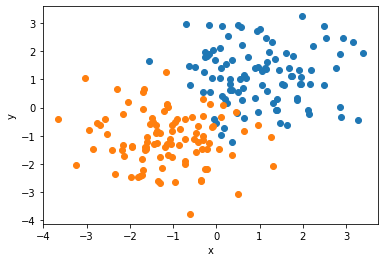

In [2]:
# In order to have reproducible results.
np.random.seed(0)

m = 200
n = 2
eps = 10e-8

# Generate data from gaussian
X_1 = np.random.normal(1, 1, size=(m//2, n))
X_2 = np.random.normal(-1, 1, size=(m//2, n))

# As the bias was ommited, let's introduce one by adding a column of ones in X
# Otherwise our hyperplan will always go through (0,0)...
X = np.hstack((np.ones((m, 1)), np.vstack((X_1, X_2))))
Y = vectorize(np.array([2*int(k < m//2) - 1 for k in range(m)]))

# Let's plot the data
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.show()

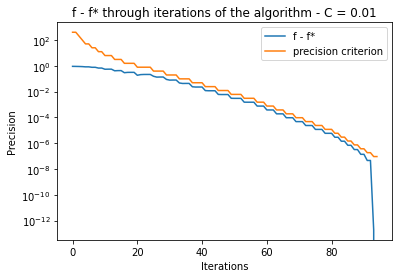

Let's stop centering step here as we cannot update v anymore


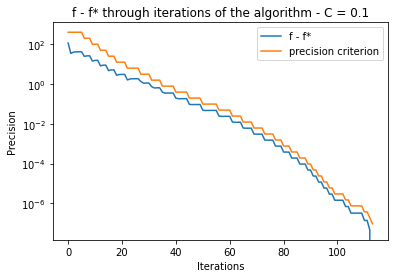

Let's stop centering step here as we cannot update v anymore
Let's stop centering step here as we cannot update v anymore
Let's stop centering step here as we cannot update v anymore


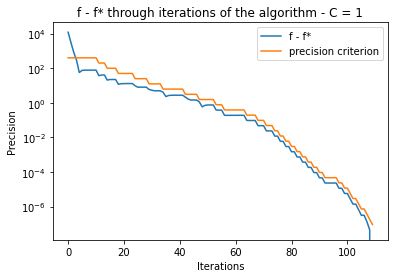

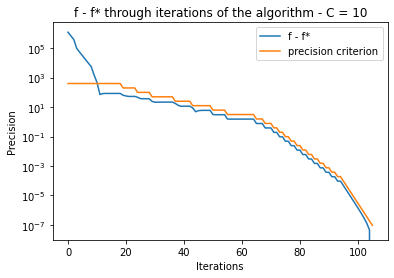

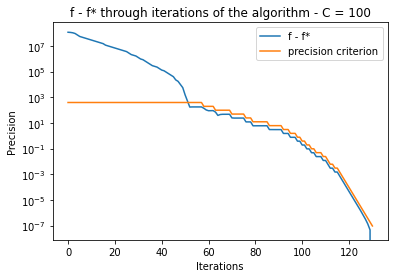

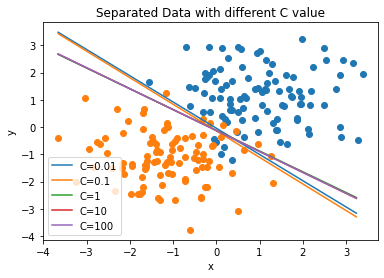

In [3]:
def dualize(X, Y, C):
    """Compute Q, A, b, p of the dual problem from the primal point of view."""
    m = X.shape[0]
    Q = 0.5 * (X * Y) @ (X * Y).T
    A = np.vstack((np.identity(m), -np.identity(m)))
    b = np.vstack((C * np.ones((m, 1)), np.zeros((m, 1))))
    return Q, A, b, -np.ones((m, 1))


def f(Q, p, v):
    return v.T @ Q @ v + p.T @ v


def sep(w, x):
    return -w[1,0]/w[2,0] * x - w[0,0]/w[2,0]


Cs = [0.01, 0.1, 1, 10, 100]
w = {}
for C in Cs:
    Q, A, b, p = dualize(X, Y, C)

    # Feasible starting point.
    v0 = C/2 * np.ones((m, 1))
    assert (A @ v0 < b).all()
    v, precision_crit = barrmethod(Q, p, A, b, v0, eps)
    
    # Plot the evolution f - f*
    f_star = f(Q, p, v[-1])[0,0]

    plt.ylabel("Precision")
    plt.xlabel("Iterations")
    plt.title(f"f - f* through iterations of the algorithm - C = {C}")
    plt.yscale("log")
    plt.plot(range(len(v)), [f(Q, p, v_i)[0,0] - f_star for v_i in v], label="f - f*")
    plt.plot(range(len(precision_crit)), precision_crit, label="precision criterion")
    plt.legend()
    plt.show()

    # Retrieve the hyperplan from the dual
    w[C] = (X * Y).T @ v[-1]


# Plot the data and the hyperplans
plt.title("Separated Data with different C value")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
for C in Cs:
    plt.plot([min(X[:,1]), max(X[:,2])], [sep(w[C], min(X[:,1])), sep(w[C], max(X[:,2]))], label=f"C={C}")
plt.legend()
plt.show()

### Higher dimension example 

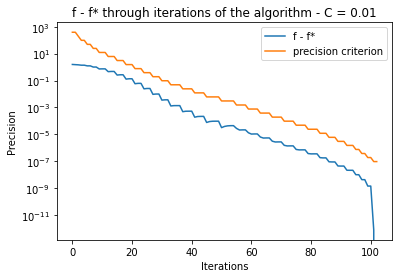

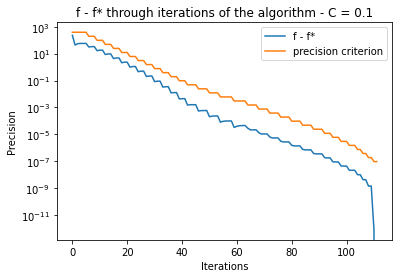

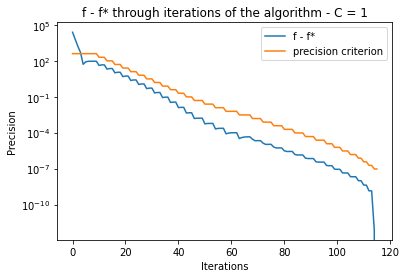

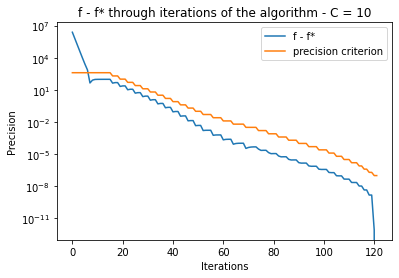

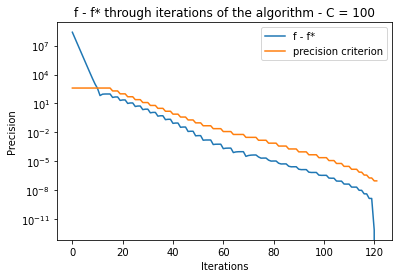

In [4]:
# In order to have reproducible results.
np.random.seed(0)

m = 2*100
n = 1000
eps = 10e-8

# Generate data from gaussian
X_1 = np.random.normal(0, 1, size=(m//2, n))
X_2 = np.random.normal(0, 1, size=(m//2, n))

# As the bias was ommited, let's introduce one by adding a column of ones in X
# Otherwise our hyperplan will always go through (0,0)...
X = np.hstack((np.ones((m, 1)), np.vstack((X_1, X_2))))
Y = vectorize(np.array([2*int(k < m//2) - 1 for k in range(m)]))


Cs = [0.01, 0.1, 1, 10, 100]
w = {}
for C in Cs:
    Q, A, b, p = dualize(X, Y, C)

    # Feasible starting point.
    v0 = C/2 * np.ones((m, 1))
    assert (A @ v0 < b).all()
    v, precision_crit = barrmethod(Q, p, A, b, v0, eps)
    
    # Plot the evolution f - f*
    f_star = f(Q, p, v[-1])[0,0]

    plt.ylabel("Precision")
    plt.xlabel("Iterations")
    plt.title(f"f - f* through iterations of the algorithm - C = {C}")
    plt.yscale("log")
    plt.plot(range(len(v)), [f(Q, p, v_i)[0,0] - f_star for v_i in v], label="f - f*")
    plt.plot(range(len(precision_crit)), precision_crit, label="precision criterion")
    plt.legend()
    plt.show()

    # Retrieve the hyperplan from the dual
    w[C] = (X * Y).T @ v[-1]

In [5]:
np.allclose(w[0.01], w[0.1]) &np.allclose(w[0.1], w[1]) & np.allclose(w[1], w[10]) & np.allclose(w[10], w[100])

True

C has no impact on w here, maybe because with high dimension (n >> m) my random datas are linearly separable.

In [6]:
# All is very well classified

w[0.01].T @ (X * Y).T > 1

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      